## Bitcoin Price Forecasting with Machine Learning
### Version 2: Application of Long Short Term Memory (LSTM) Model with Feature Engineering

This notebook demonstrates the process of forecasting Bitcoin prices using machine learning techniques. We will go through the following steps:
1. Loading and exploring the dataset
2. Feature Engineering
3. Normalization
4. Splitting the data into training and testing sets
5. Creation of the LSTM Model
6. Evaluating the model
7. Forecasting future prices

Data source: `https://www.investing.com/crypto/bitcoin/historical-data`

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

## Step 1: Load and Explore the Data

First, we'll load the dataset and explore its structure.

In [55]:
# Load and sort the data
data_full = pd.read_csv('./datasets/coin_Bitcoin.csv', parse_dates=['Date'], index_col='Date')
data_full = data_full.sort_index()

# # Filter the data to start from 2013-01-01 until 2024-04-30
# data = data_full.loc['2013-01-01':'2024-04-30']

data = data_full

In [56]:
data.head()

,Close,Open,High,Low
Date,,,,
2013-01-01,13.3,13.5,13.6,13.2
2013-01-02,13.3,13.3,13.4,13.2
2013-01-03,13.4,13.3,13.5,13.3
2013-01-04,13.5,13.4,13.5,13.3
2013-01-05,13.4,13.5,13.6,13.3


## Step 2: Feature Engineering

### Moving Averages
#### Purpose: 
- To smooth out short-term fluctuations and highlight longer-term trends or cycles.

#### How it helps:
1. Trend Detection: Moving averages help in identifying the underlying trend direction of the data, whether it's up, down, or sideways.
2. Noise Reduction: Averaging out the data points over a time period, there is the reduction of the impact of random fluctuations (noise) (making it easier to observe the true movement of the price).
3. Support and Resistance Levels: In trading, moving averages often act as support and resistance levels. This can be useful in predicting potential future price movements based on historical data.

### Price Changes (Daily Change)
#### Purpose: 
- To measure the rate of change in price, which helps in understanding the momentum of price movements.

#### How it helps:
- Momentum Indicators: The daily percentage change gives an idea of the momentum in the market. Higher momentum could indicate a strong trend, while lower momentum might suggest a weakening trend.

### Volatility Insight: 
Trend Reversal Signals: Significant changes in the daily price can sometimes indicate potential trend reversals or confirm the continuation of a trend.
#### Purpose:
- Observing the magnitude of daily changes helps in assessing the market's volatility. Large price changes indicate high volatility, while small changes suggest low volatility.
- To measure the degree of variation in trading prices over time, which indicates the level of market risk and uncertainty.

#### How it helps:
1. Risk Assessment: Volatility is a key measure of risk in financial markets. High volatility indicates higher risk and uncertainty, while low volatility suggests stability.
2. Market Sentiment: Volatility can reflect market sentiment. High volatility often accompanies market panic or euphoria, while low volatility is seen in more stable, confident market conditions.
3. Forecasting: Including volatility in the model helps capture periods of market turbulence or calmness, improving the model's ability to make accurate predictions under varying market conditions.

## Summary
Incorporating these elements into your model helps capture a more comprehensive picture of the market dynamics:

1. Moving Averages: Capture long-term trends and reduce noise.
2. Price Changes: Provide insights into momentum and potential trend reversals.
3. Volatility Index: Assess market risk and improve the model's responsiveness to different market conditions.

- By considering these factors, our predictive model becomes more robust and capable of making more accurate forecasts.

In [57]:
# Feature Engineering
data['7_day_MA'] = data['Close'].rolling(window=7).mean()
data['14_day_MA'] = data['Close'].rolling(window=14).mean()
data['30_day_MA'] = data['Close'].rolling(window=30).mean()
data['Daily_Change'] = data['Close'].pct_change()
data['Volatility'] = data['Close'].rolling(window=7).std()
data = data.dropna()

In [58]:
# Split data into features and target
features = data[['7_day_MA', '14_day_MA', '30_day_MA', 'Daily_Change', 'Volatility']]
target = data['Close']

## Step 3: Normalization of the data
Next, we'll Normalize the data then split it 80/20 as training and testing sets.

In [59]:
# Normalize the features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

features_scaled = feature_scaler.fit_transform(features)
target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1))

## Step 4: Train-Test Split
We will split the data into training and testing sets. We'll use the last year in the dataset for testing.

In [60]:
# Split data into training and test sets
train_size = int(len(features) * 0.8)
X_train, X_test = features_scaled[:train_size], features_scaled[train_size:]
y_train, y_test = target_scaled[:train_size], target_scaled[train_size:]

In [61]:
# Reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

## Step 5: Creation of the LSTM Model

- LSTM models are well-suited for financial time series prediction because of their ability to:
    1. Handle sequential data, remember long-term dependencies
    2. Adapt to the volatile nature of financial markets.
- Thus LSTM networks can provide more accurate and reliable predictions for Bitcoin prices.

In [62]:
# Build and train LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20


c:\Users\pboba\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0361
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.8257e-04
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.7050e-04
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5706e-04
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7038e-04
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7841e-04
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2771e-04
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3678e-04
Epoch 9/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0935e-04
Epoch 10/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6058e-04
Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3958e-04
Epoch 12/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0329e-04
Epoch 13/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9861e-04
Epoch 14/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7382e-04
Epoch 15/20
104/

In [63]:
# Predict and inverse transform the predictions
predicted_scaled = model.predict(X_test)
predicted = target_scaler.inverse_transform(predicted_scaled)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 


## Step 6: Evaluate the Model
We will evaluate the model by predicting the Bitcoin prices on the test set and calculating the RMSE. We will also visualize the actual vs. predicted prices from both train and test.

In [64]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(target_scaler.inverse_transform(y_test), predicted))
print(f"Root Mean Squared Error: {rmse}")

Root Mean Squared Error: 1488.360640681254


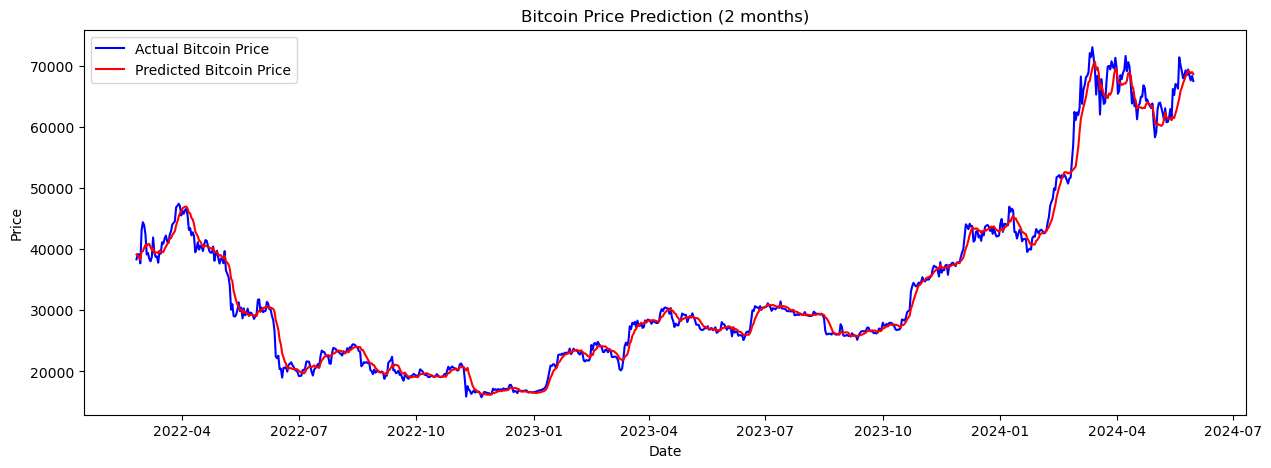

In [65]:
# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(data.index[train_size:], target_scaler.inverse_transform(y_test), color='blue', label='Actual Bitcoin Price')
plt.plot(data.index[train_size:], predicted, color='red', label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction (2 months)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Step 7: Forecast Future Prices
Finally, we will forecast the Bitcoin prices for the next year using the trained model.

In [66]:
# Save the data
data.to_csv('./datasets/processed_data.csv')

In [67]:
# Apply the model to predict future prices for the next 90 days
future_features_90 = features_scaled[-90:]
future_features_90 = future_features_90.reshape((future_features_90.shape[0], 1, future_features_90.shape[1]))
future_predicted_scaled_90 = model.predict(future_features_90)
future_predicted_90 = target_scaler.inverse_transform(future_predicted_scaled_90)

# Create a dataframe with the future predictions
future_dates_90 = pd.date_range(start=data.index[-1], periods=90)
future_predictions_90 = pd.DataFrame(future_predicted_90, index=future_dates_90, columns=['Predicted'])
future_predictions_90.head()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,Predicted
2024-05-31,59221.671875
2024-06-01,61352.054688
2024-06-02,62286.695312
2024-06-03,63240.609375
2024-06-04,64050.183594


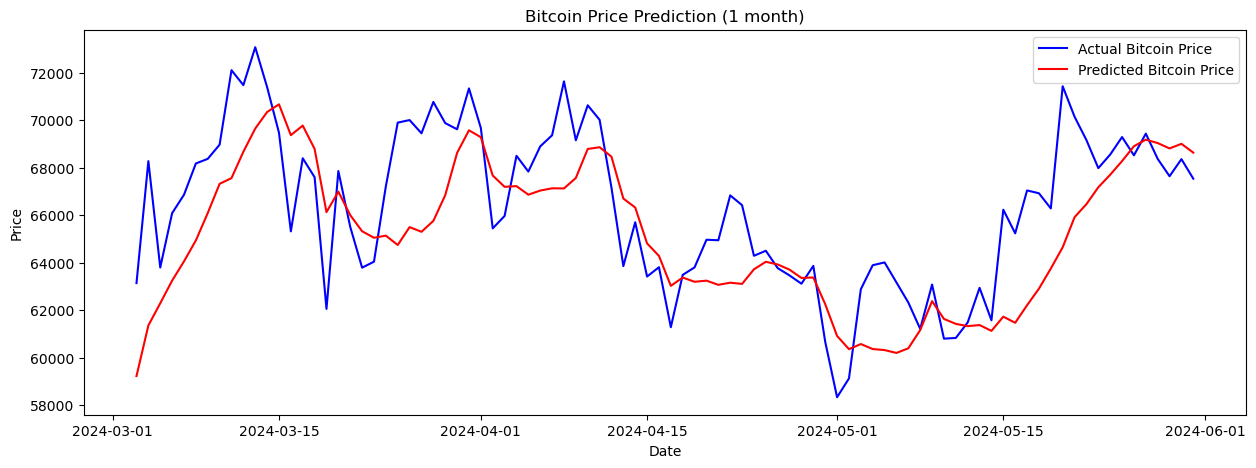

In [68]:
# Plot the actual and predicted prices for the next 90 days
plt.figure(figsize=(15, 5))
plt.plot(data.index[-90:], target_scaler.inverse_transform(target_scaled[-90:]), color='blue', label='Actual Bitcoin Price')
plt.plot(data.index[-90:], future_predicted_90, color='red', label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction (1 month)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [75]:
# Apply the model to predict future prices for the next 60 days
future_features_60 = features_scaled[-60:]
future_features_60 = future_features_60.reshape((future_features_60.shape[0], 1, future_features_60.shape[1]))
future_predicted_scaled_60 = model.predict(future_features_60)
future_predicted_60 = target_scaler.inverse_transform(future_predicted_scaled_60)

# Create a dataframe with the future predictions
future_dates_60 = pd.date_range(start=data.index[-1], periods=60)
future_predictions_60 = pd.DataFrame(future_predicted_60, index=future_dates_60, columns=['Predicted'])
future_predictions_60.head()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,Predicted
2024-05-31,67664.640625
2024-06-01,67188.625000
2024-06-02,67219.304688
2024-06-03,66857.703125
2024-06-04,67031.132812


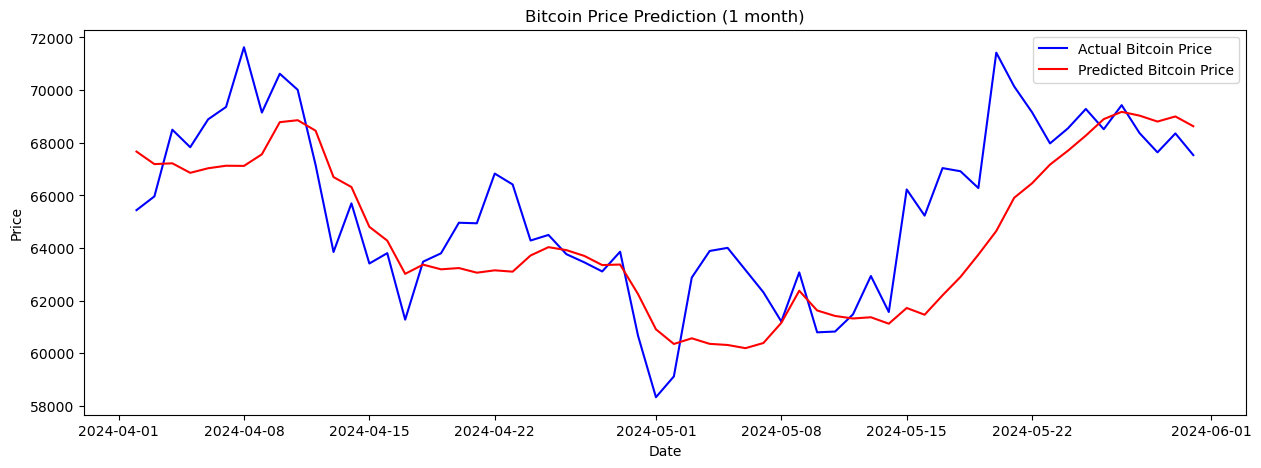

In [70]:
# Plot the actual and predicted prices for the next 60 days
plt.figure(figsize=(15, 5))
plt.plot(data.index[-60:], target_scaler.inverse_transform(target_scaled[-60:]), color='blue', label='Actual Bitcoin Price')
plt.plot(data.index[-60:], future_predicted_60, color='red', label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction (1 month)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [87]:
# Create a new dataset of future_predictions_60 Predicted column with the actual data from ./datasets/coin_Bitcoin_full.csv - 'Close' column; 2024-05-31 to 2024-06-18
# Columns: Date, Predicted, Actual
data_full = pd.read_csv('./datasets/coin_Bitcoin_full.csv', parse_dates=['Date'], index_col='Date')
data_full = data_full.sort_index()
data_full = data_full.loc['2024-06-01':'2024-06-18']
data_compare = data_full[['Close']]

# Filter future predictions to match the dates
data_compare['Predicted'] = future_predictions_60.loc['2024-06-01':'2024-06-18']

# Add a column with the difference between the predicted and actual prices as a percentage
data_compare['% Difference'] = (data_compare['Predicted'] - data_compare['Close']) / data_compare['Close'] * 100

# Save the data
data_compare.to_csv('./datasets/compare_data.csv')
data_compare


C:\Users\pboba\AppData\Local\Temp\ipykernel_14076\1117504317.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_compare['Predicted'] = future_predictions_60.loc['2024-06-01':'2024-06-19']
C:\Users\pboba\AppData\Local\Temp\ipykernel_14076\1117504317.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_compare['% Difference'] = (data_compare['Predicted'] - data_compare['Close']) / data_compare['Close'] * 100


,Close,Predicted,% Difference
Date,,,
2024-06-01,67760.8,67188.625000,-0.844404
2024-06-02,67773.5,67219.304688,-0.817717
2024-06-03,68807.8,66857.703125,-2.834122
2024-06-04,70549.2,67031.132812,-4.986686
2024-06-05,71083.7,67127.007812,-5.566244
2024-06-06,70791.5,67120.734375,-5.185320
2024-06-07,69347.9,67561.531250,-2.575952
2024-06-08,69310.1,68782.757812,-0.760845
2024-06-09,69650.6,68856.757812,-1.139749


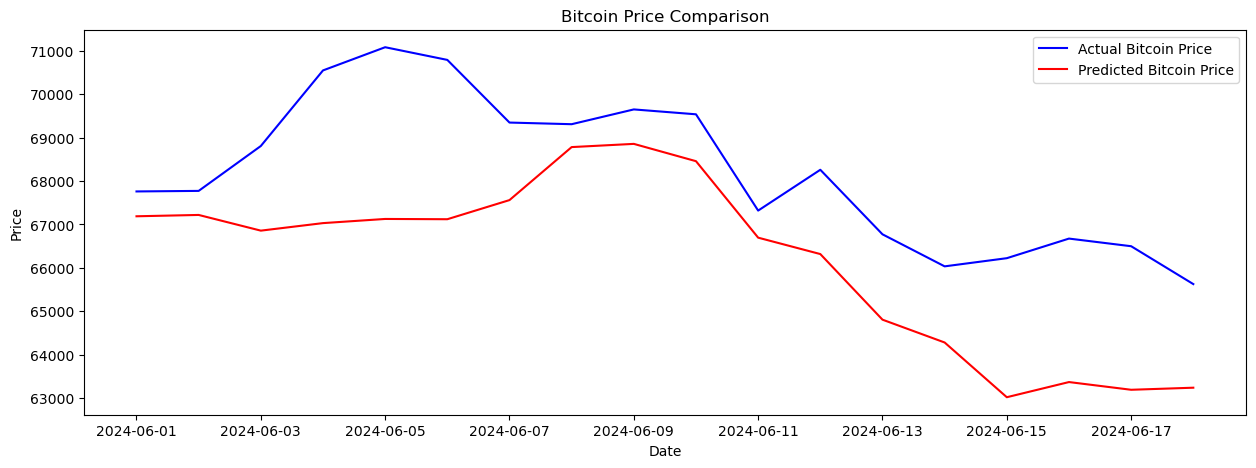

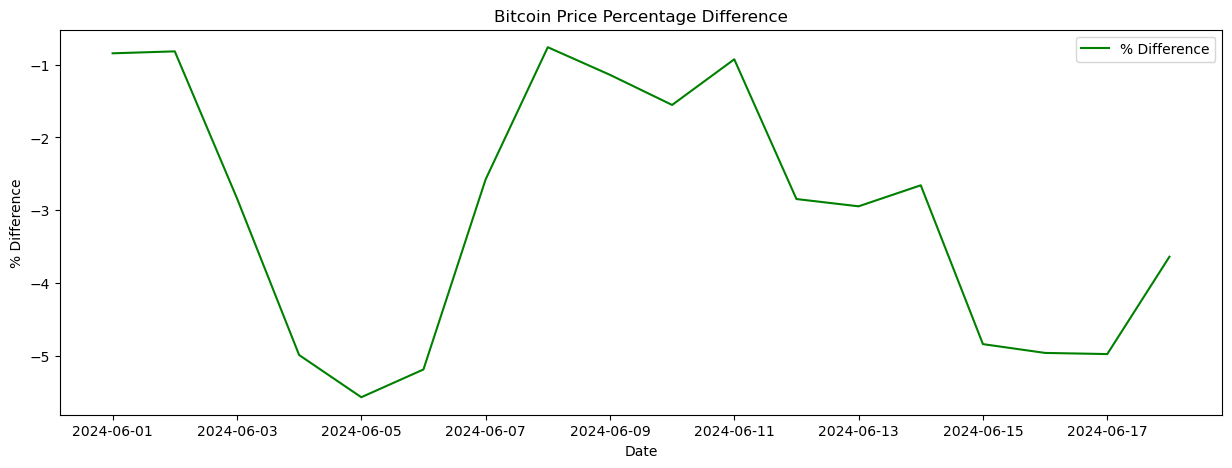

In [89]:
# Plot data_compare highlighting the % Difference
plt.figure(figsize=(15, 5))
plt.plot(data_compare.index, data_compare['Close'], color='blue', label='Actual Bitcoin Price')
plt.plot(data_compare.index, data_compare['Predicted'], color='red', label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot the % Difference
plt.figure(figsize=(15, 5))
plt.plot(data_compare.index, data_compare['% Difference'], color='green', label='% Difference')
plt.title('Bitcoin Price Percentage Difference')
plt.xlabel('Date')
plt.ylabel('% Difference')
plt.legend()
plt.show()


In this final step, we generate future dates and use the trained model to predict Bitcoin prices for the next year. We also plot the predicted future prices to visualize the forecast.

The predicted prices capture the overall declining trend seen in the actual prices but fail to capture the short-term fluctuations and volatility.

The predictions are generally lower than the actual prices, especially noticeable in the first half of June.

The LSTM model smoothes out the predictions as it struggles to capture high frequency variations.